In [35]:
import os
import pandas as pd
import numpy as np
import pickle

test = pd.read_parquet('../testbed/test/test.parquet')
test_expert_pred = pd.read_parquet('../testbed/test/test_expert_pred.parquet')
with open(f"ova_predictions.pkl", "rb") as input_file:
    ova = pickle.load(input_file)

experts = ova['small-1_regular'].columns

test_ec = pd.DataFrame(index = test.index, columns = experts)
test_ew = pd.DataFrame(index = test.index, columns = experts)
outcomes_df = pd.DataFrame(index = test.index, columns = experts)

for expert in experts:
    test_ec.loc[:,expert] = (test['fraud_label'] == test_expert_pred[expert])
    test_ew.loc[:,expert] = (test['fraud_label'] != test_expert_pred[expert])

outcomes_df[test_ec] = 1
outcomes_df[test_ew] = 0

In [36]:
from sklearn import metrics
curves = dict()
for env_id in ova:
    preds = ova[env_id]
    curves[env_id] = dict()
    for expert in preds.columns:
        y_pred = preds[expert]
        y_true = outcomes_df[expert]
        fpr, tpr,_ = metrics.roc_curve(y_true = y_true.astype(int).to_numpy(), y_score = y_pred.to_numpy())
        auc = metrics.roc_auc_score(y_true = y_true.astype(int).to_numpy(), y_score = y_pred.to_numpy())
        curves[env_id][expert] = {'fpr': fpr,
                                  'tpr': tpr,
                                  'auc': auc}

        

dict_keys(['small-1_regular', 'small-2_regular', 'small-3_regular', 'small-4_regular', 'small-5_regular'])


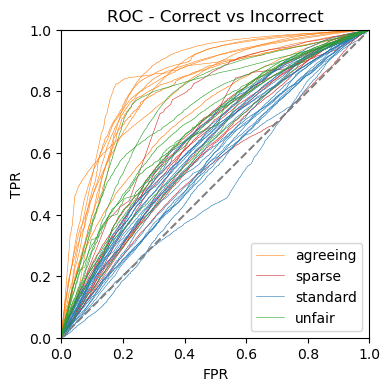

In [37]:
from matplotlib import pyplot as plt

import seaborn as sns

f, ax = plt.subplots(figsize=(4, 4))
pal = sns.color_palette(['C0','C1','C2', 'C3'])
pal = pal.as_hex()

print(curves.keys())
train_env = 'small-1_regular'
exp = curves[train_env]


reg_counter = 0
ma_counter = 0
un_counter = 0
sp_counter = 0
for expert in preds.columns:
    setlabel = None
    if expert.split('#')[0] == 'standard':
        color = pal[0]
        if(reg_counter == 0):
            setlabel = 'standard'
            reg_counter +=1
    elif expert.split('#')[0] == 'model_agreeing':
        color = pal[1]
        if(ma_counter == 0):
            setlabel = 'agreeing'
            ma_counter+=1
    elif expert.split('#')[0] == 'unfair':
        color = pal[2]
        if(un_counter == 0):
            setlabel = 'unfair'
            un_counter += 1
    elif expert.split('#')[0] == 'sparse':
        color = pal[3]
        if(sp_counter == 0):
            setlabel = 'sparse'
            sp_counter += 1
    plt.plot(exp[expert]['fpr'],exp[expert]['tpr'], c = color, linewidth = 0.4, label = setlabel)


plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC - Correct vs Incorrect')
plt.legend()
plt.savefig("ROC_OvA.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [38]:
hem = pd.DataFrame(columns = ['training_seed', 'expert', 'e_auc'])

for env_id in curves:
    for expert in outcomes_df.columns:
        if expert == 'all':
            continue
        hem = hem.append(pd.Series([env_id, expert, curves[env_id][expert]['auc']], index = hem.columns), ignore_index=True)

In [39]:
hem.groupby(by = 'expert').mean().reset_index().set_index('expert').loc[test_expert_pred.columns.drop('model#0'),:].round(3)

,e_auc
standard#0,0.642
standard#1,0.576
standard#2,0.620
standard#3,0.575
standard#4,0.595
standard#5,0.623
standard#6,0.581
standard#7,0.639
standard#8,0.638
standard#9,0.611
